In [29]:
import os
import sys
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])

api_dir = str(curr_dir)
if api_dir not in sys.path:
    sys.path.insert(0, api_dir)
    
from datetime import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from src.handler import XBox2ContextDataCreator
from src.model.classifier import Classifier
from src.utils.dataset_creator import load_dataset
from src.datasets.ECG200 import ECG200
from src.model.explainer import explain_samples
from src.model.sample_explainers.gradient_shap import ShapGradientExplainer

not_swan_default_modules = ["shap","coloredlogs"]
for name in not_swan_default_modules:
    if not name in sys.modules:
        !pip install --user name

# Load dataset
dataset from https://www.timeseriesclassification.com/description.php?Dataset=ECG200

In [2]:
train, valid, test = load_dataset(creator=ECG200(), data_path=Path(api_dir) / "src/datasets/ECG200")

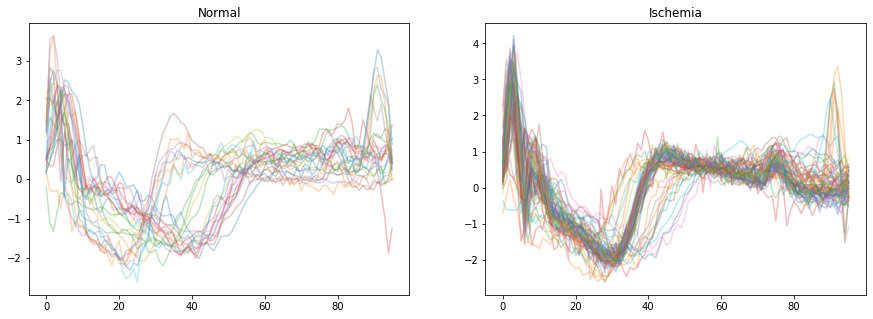

In [3]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(train.X[train.y.argmax(axis=1) == 0][:,:,0].T, alpha=0.3)
ax[0].set_title("Normal")
ax[1].plot(train.X[train.y.argmax(axis=1) == 1][:,:,0].T, alpha=0.3)
ax[1].set_title("Ischemia")
plt.show()

# Classify heartbeats

In [174]:
# Load hyperparameters
hp_file = open(Path(api_dir) / "src/model/default_hyperparameters.json")
hp_dict = json.load(hp_file)
hp_dict

In [175]:
# define and fit classifier
clf = Classifier(input_shape=train.X.shape, output_directory=Path(api_dir) / "src/output", **hp_dict)
clf.fit_classifier(train, valid)

Epoch 1/200
6/6 [==============================] - 2s 289ms/step - loss: 0.6031 - tp: 61.0000 - fp: 29.0000 - tn: 61.0000 - fn: 29.0000 - accuracy: 0.6778 - precision: 0.6778 - recall: 0.6778 - auc: 0.7198 - prc: 0.6661 - val_loss: 1.0209 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.4800 - val_prc: 0.4730
Epoch 2/200
6/6 [==============================] - 0s 38ms/step - loss: 0.6014 - tp: 65.0000 - fp: 25.0000 - tn: 65.0000 - fn: 25.0000 - accuracy: 0.7222 - precision: 0.7222 - recall: 0.7222 - auc: 0.7046 - prc: 0.6537 - val_loss: 0.8745 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.5200 - val_prc: 0.5039
Epoch 3/200
6/6 [==============================] - 0s 37ms/step - loss: 0.5981 - tp: 65.0000 - fp: 25.0000 - tn: 65.0000 - fn: 25.0000 - accuracy: 0.7222 - precision: 0.7222 - rec

Epoch 21/200
6/6 [==============================] - 0s 25ms/step - loss: 0.3736 - tp: 75.0000 - fp: 15.0000 - tn: 75.0000 - fn: 15.0000 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.9152 - prc: 0.9180 - val_loss: 0.7193 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.7450 - val_prc: 0.7787
Epoch 22/200
6/6 [==============================] - 0s 22ms/step - loss: 0.3886 - tp: 76.0000 - fp: 14.0000 - tn: 76.0000 - fn: 14.0000 - accuracy: 0.8444 - precision: 0.8444 - recall: 0.8444 - auc: 0.9010 - prc: 0.9044 - val_loss: 0.6270 - val_tp: 8.0000 - val_fp: 2.0000 - val_tn: 8.0000 - val_fn: 2.0000 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000 - val_auc: 0.8200 - val_prc: 0.8347
Epoch 23/200
6/6 [==============================] - 0s 29ms/step - loss: 0.3951 - tp: 75.0000 - fp: 15.0000 - tn: 75.0000 - fn: 15.0000 - accuracy: 0.8333 - precision: 0.8333 - r

Epoch 41/200
6/6 [==============================] - 0s 28ms/step - loss: 0.2252 - tp: 81.0000 - fp: 9.0000 - tn: 81.0000 - fn: 9.0000 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9741 - prc: 0.9755 - val_loss: 0.5359 - val_tp: 7.0000 - val_fp: 3.0000 - val_tn: 7.0000 - val_fn: 3.0000 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000 - val_auc: 0.8300 - val_prc: 0.8517
Epoch 42/200
6/6 [==============================] - 0s 21ms/step - loss: 0.2683 - tp: 80.0000 - fp: 10.0000 - tn: 80.0000 - fn: 10.0000 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9572 - prc: 0.9584 - val_loss: 0.2120 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 9.0000 - val_fn: 1.0000 - val_accuracy: 0.9000 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9900 - val_prc: 0.9905
Epoch 43/200
6/6 [==============================] - 0s 29ms/step - loss: 0.2632 - tp: 78.0000 - fp: 12.0000 - tn: 78.0000 - fn: 12.0000 - accuracy: 0.8667 - precision: 0.8667 - rec

Epoch 61/200
6/6 [==============================] - 0s 20ms/step - loss: 0.1392 - tp: 87.0000 - fp: 3.0000 - tn: 87.0000 - fn: 3.0000 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9898 - prc: 0.9901 - val_loss: 0.4533 - val_tp: 7.0000 - val_fp: 3.0000 - val_tn: 7.0000 - val_fn: 3.0000 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000 - val_auc: 0.8500 - val_prc: 0.8719
Epoch 62/200
6/6 [==============================] - 0s 30ms/step - loss: 0.1360 - tp: 87.0000 - fp: 3.0000 - tn: 87.0000 - fn: 3.0000 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9905 - prc: 0.9908 - val_loss: 0.4900 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.8400 - val_prc: 0.8654
Epoch 63/200
6/6 [==============================] - 0s 25ms/step - loss: 0.1401 - tp: 85.0000 - fp: 5.0000 - tn: 85.0000 - fn: 5.0000 - accuracy: 0.9444 - precision: 0.9444 - recall:

Epoch 81/200
6/6 [==============================] - 0s 34ms/step - loss: 0.0894 - tp: 87.0000 - fp: 3.0000 - tn: 87.0000 - fn: 3.0000 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9964 - prc: 0.9965 - val_loss: 0.6520 - val_tp: 7.0000 - val_fp: 3.0000 - val_tn: 7.0000 - val_fn: 3.0000 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000 - val_auc: 0.8300 - val_prc: 0.8496
Epoch 82/200
6/6 [==============================] - 0s 28ms/step - loss: 0.0823 - tp: 88.0000 - fp: 2.0000 - tn: 88.0000 - fn: 2.0000 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9980 - prc: 0.9981 - val_loss: 0.2261 - val_tp: 8.0000 - val_fp: 2.0000 - val_tn: 8.0000 - val_fn: 2.0000 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000 - val_auc: 0.9400 - val_prc: 0.9451
Epoch 83/200
6/6 [==============================] - 0s 24ms/step - loss: 0.1171 - tp: 84.0000 - fp: 6.0000 - tn: 84.0000 - fn: 6.0000 - accuracy: 0.9333 - precision: 0.9333 - recall:

Epoch 101/200
6/6 [==============================] - 0s 26ms/step - loss: 0.0643 - tp: 89.0000 - fp: 1.0000 - tn: 89.0000 - fn: 1.0000 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9988 - prc: 0.9988 - val_loss: 0.6806 - val_tp: 8.0000 - val_fp: 2.0000 - val_tn: 8.0000 - val_fn: 2.0000 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000 - val_auc: 0.8700 - val_prc: 0.8833
Epoch 102/200
6/6 [==============================] - 0s 28ms/step - loss: 0.0676 - tp: 89.0000 - fp: 1.0000 - tn: 89.0000 - fn: 1.0000 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9969 - prc: 0.9970 - val_loss: 0.3615 - val_tp: 8.0000 - val_fp: 2.0000 - val_tn: 8.0000 - val_fn: 2.0000 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000 - val_auc: 0.9200 - val_prc: 0.9288
Epoch 103/200
6/6 [==============================] - 0s 27ms/step - loss: 0.0662 - tp: 88.0000 - fp: 2.0000 - tn: 88.0000 - fn: 2.0000 - accuracy: 0.9778 - precision: 0.9778 - reca

Epoch 121/200
6/6 [==============================] - 0s 32ms/step - loss: 0.0208 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.6347 - val_tp: 8.0000 - val_fp: 2.0000 - val_tn: 8.0000 - val_fn: 2.0000 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000 - val_auc: 0.9200 - val_prc: 0.9288
Epoch 122/200
6/6 [==============================] - 0s 37ms/step - loss: 0.0202 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.5379 - val_tp: 8.0000 - val_fp: 2.0000 - val_tn: 8.0000 - val_fn: 2.0000 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000 - val_auc: 0.9200 - val_prc: 0.9288
Epoch 123/200
6/6 [==============================] - 0s 34ms/step - loss: 0.0199 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - 

Epoch 141/200
6/6 [==============================] - 0s 32ms/step - loss: 0.0089 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.5537 - val_tp: 8.0000 - val_fp: 2.0000 - val_tn: 8.0000 - val_fn: 2.0000 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000 - val_auc: 0.9200 - val_prc: 0.9288
Epoch 142/200
6/6 [==============================] - 0s 25ms/step - loss: 0.0093 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.5153 - val_tp: 8.0000 - val_fp: 2.0000 - val_tn: 8.0000 - val_fn: 2.0000 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000 - val_auc: 0.9200 - val_prc: 0.9288
Epoch 143/200
6/6 [==============================] - 0s 26ms/step - loss: 0.0110 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - 

Epoch 161/200
6/6 [==============================] - 0s 16ms/step - loss: 0.0044 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.5770 - val_tp: 8.0000 - val_fp: 2.0000 - val_tn: 8.0000 - val_fn: 2.0000 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000 - val_auc: 0.9200 - val_prc: 0.9288
Epoch 162/200
6/6 [==============================] - 0s 26ms/step - loss: 0.0049 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.5156 - val_tp: 8.0000 - val_fp: 2.0000 - val_tn: 8.0000 - val_fn: 2.0000 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000 - val_auc: 0.9200 - val_prc: 0.9288
Epoch 163/200
6/6 [==============================] - 0s 34ms/step - loss: 0.0040 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - 

Epoch 181/200
6/6 [==============================] - 0s 26ms/step - loss: 0.0029 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.5179 - val_tp: 8.0000 - val_fp: 2.0000 - val_tn: 8.0000 - val_fn: 2.0000 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000 - val_auc: 0.9400 - val_prc: 0.9451
Epoch 182/200
6/6 [==============================] - 0s 23ms/step - loss: 0.0031 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7580 - val_tp: 8.0000 - val_fp: 2.0000 - val_tn: 8.0000 - val_fn: 2.0000 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000 - val_auc: 0.9200 - val_prc: 0.9288
Epoch 183/200
6/6 [==============================] - 0s 26ms/step - loss: 0.0024 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - 

In [176]:
# make predictions
y_pred = clf.model.predict(x=test.X)

In [177]:
# eval classifier
results = clf.model.evaluate(x=test.X, y=test.y, return_dict=True)
pd.DataFrame.from_dict(results, orient='index').T

4/4 [==============================] - 0s 5ms/step - loss: 1.0131 - tp: 82.0000 - fp: 18.0000 - tn: 82.0000 - fn: 18.0000 - accuracy: 0.8200 - precision: 0.8200 - recall: 0.8200 - auc: 0.9020 - prc: 0.8848


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,1.013115,82.0,18.0,82.0,18.0,0.82,0.82,0.82,0.902,0.884803


# Explain predictions

In [178]:
is_correct_pred = (y_pred.argmax(axis=1) == test.y.argmax(axis=1))
ex_pred = explain_samples(explainer=ShapGradientExplainer(),
                                 model=clf.model,
                                 X_reference=train.X,
                                 X_to_explain=test.X[is_correct_pred, :, :])

In [179]:
def plot_importance(X_to_explain, y_pred, explanation):
    cmap = mpl.colors.LinearSegmentedColormap.from_list('shap', [mpl.cm.cool(0), (1, 1, 1, 1), mpl.cm.cool(256)],N=256)
    
    fig, ax = plt.subplots(figsize=(7,5))  
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 0), :, :].mean(axis=0), linewidth=3, c="b")
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 1), :, :].mean(axis=0), linewidth=3, c="r")
    
    extent = [0, len(X_to_explain[0]), ax.get_ylim()[0], ax.get_ylim()[1]]
    im1 = ax.imshow(explanation[0].mean(axis=0).T, cmap=cmap, aspect="auto", alpha=0.8, extent=extent)  
    cbar1 = fig.colorbar(im1, ax=ax)
    cbar1.set_label("SHAP values (relative)")

    ax.set_xlabel("samples")
    ax.set_title("Explanations of Correct Predictions")
    ax.legend(["mean normal","mean ischemia"])

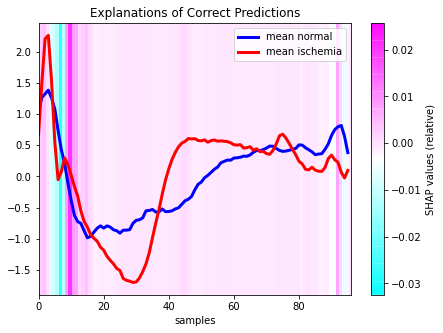

In [180]:
plot_importance(X_to_explain = test.X, y_pred = y_pred, explanation = ex_pred)